# Notebook 2: Baselines and Multi-Layer Perceptrons

In this notebook we begin exploring basic classification approaches, and we apply our first deep learning model to this task. In addition, we create a elegant framework for running experiments easily, and define our experiment. 

In addition to this, we evaluate some non-DL baselines provided by [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3547887) and the supporting tutorial.

Finally, we render some illustrations to help us visualize the training process.

Highlights!

1. We implement our deep learning experimentation framework from scratch, implementing many functioanlities explicitly.

2. We render some fun illustrations such as our confusion matrix animation to understand our models. 

3. We deliver results in a zip structure that is useful for analysis



Contents:

1.   Data exploration 
2.   Traditional ML baselines as in [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3547887)
3.   Custom deep learning experiment framework and MLP training



In [ ]:
# Imports 
!pip install gensim==4.2.0
!pip install matplotlib==3.4

import gdown
import glob
import os
import re
import json
import math
import time
from datetime import datetime
import csv
import string
import matplotlib
from nltk import pos_tag

import zipfile
import torch
from torch import nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from torchsummary import summary
from sklearn.metrics import accuracy_score
from nltk import word_tokenize, PorterStemmer
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Constants
FILMS_GENRE = [
    "action",
    "adventure",
    "comedy",
    "drama",
    "horror",
    "romance",
    "scifi", # science fiction
    "fantasy",
    "historical",
    "crime"
]

TARGET_LKP = {
    "action": 0,
    "adventure": 1,
    "comedy": 2,
    "drama": 3,
    "horror": 4,
    "romance": 5,
    "scifi": 6,  # science fiction
    "fantasy": 7,
    "historical": 8,
    "crime": 9
}

print(matplotlib.__version__)

3.4.0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Fetch the data
!gdown 10fAkL5gOYjG0WcNIwZnZ1X9_n8pciT19
os.makedirs("/content/data/", exist_ok=True)
!cp /content/data_full3.zip /content/data/
path = "/content/data/data_full3.zip"

initial_df = pd.DataFrame()
with zipfile.ZipFile(path) as z:
  for name in z.namelist():
    if name.endswith(".csv"):
      print(f'Loading data from {name}...')
      x = pd.read_csv(z.open(name))
      print(f'Loading completed from {name}...')
      initial_df = pd.concat([initial_df,x[['genre','plot']]],axis=0,ignore_index=True)
  print("Dataframe (df) ready to be used!")

initial_df

Downloading...
From: https://drive.google.com/uc?id=10fAkL5gOYjG0WcNIwZnZ1X9_n8pciT19
To: /content/data_full3.zip
100% 5.15M/5.15M [00:00<00:00, 17.4MB/s]
Loading data from content/gdrive/MyDrive/CS5242_Project_Data/action/action_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data/action/action_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data/adventure/adventure_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data/adventure/adventure_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data/comedy/comedy_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data/comedy/comedy_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data/drama/drama_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data/drama/drama_films.csv...
Loading data from content/gdrive/MyDrive/CS5242_Project_Data/horror/horror_films.csv...
Loading completed from co

,genre,plot
0,action,frank vega is a decorated vietnam war veteran ...
1,action,journalist matt nashs dylan walsh investigatio...
2,action,in the midtolate 1960s three young men leave t...
3,action,po sing the youngest son of chinese triad boss...
4,action,clay santell audie murphy has his horse stolen...
...,...,...
2677,crime,a mexican newspaperman wages a oneman war agai...
2678,crime,larry crain peter cookson a medical student on...
2679,crime,a texas ranger samantha payne opens up a fifte...
2680,crime,billy dempsey is a well dressed bank robber wh...


# Data Exploration and Baselines

---



We first look for some common sources of error in the dataset, before we begin using it. The three most common erorrs are:

1.   Plot is null 
2.   Plot is empty
3.   Extraction of the plot caused error

Since this dataset is created by scraping through wikipedia, it can result in a noisy dataset, where the rows might be incomplete. We look for these errors first, and then begin by looking at the distribution of the datset. 

In [ ]:
# 2(iii) - 1: Page with Section on Plot but contains no text, thus null or blank
plot_null_df = initial_df.loc[(initial_df['plot']=="") | (initial_df['plot'].isnull()) ]
plot_null_df['plot'] = "Null" #for plotting the null values

# 2(iii) - 2:Page with no Section on Plot
no_section_plot_df = initial_df[initial_df['plot'] == "Page with no Section on Plot"]

# 2(iii) - 3: Error (Unable to extract)
error_plot_df = initial_df[initial_df['plot'] == "error"]

# 2(iii): removal of rows mentioned above to form final dataset that is useable
df = initial_df.copy()
df = df[~df['plot'].isnull()]
df = df[df['plot'] != ""]
df = df[df['plot'] != "Page with no Section on Plot"]
df = df[df['plot'] != "error"]
df.reset_index(drop=True,inplace=True)

#Commence plotting
plt.figure(figsize = (30,15))
# 1st visual
if plot_null_df.size > 0:
  plt.subplot(2,2,1)
  plt.title("Number of films by Genre with Null/Blank plot")

  ax = sns.countplot(x = 'genre', data = plot_null_df) #order=plot_null_df['genre'].value_counts(ascending=False).index
  abs_values = plot_null_df['genre'].value_counts(sort=False).values
  ax.bar_label(container=ax.containers[0], labels=abs_values)
else:
  print ("There are no films with null plots")

# 2nd visual
if no_section_plot_df.size > 0:
  plt.subplot(2,2,2)
  plt.title("Number of Films by Genre without section on plot")

  ax = sns.countplot(x = 'genre', data = no_section_plot_df) #order=no_section_plot_df['genre'].value_counts(ascending=False).index
  abs_values = no_section_plot_df['genre'].value_counts(sort=False).values
  ax.bar_label(container=ax.containers[0], labels=abs_values)
else:
  print("There are no films with missing plot sections in this dataset")

# 3rd visual -- There are no errors in this dataset, for other random_state, errors do exist.

if error_plot_df.size > 0:
  plt.subplot(2,2,3)
  plt.title("Number of Films by Genre with error")

  ax = sns.countplot(x = 'genre', data = error_plot_df,order=error_plot_df['genre'].value_counts(ascending=False).index)
  abs_values = error_plot_df['genre'].value_counts(ascending=False).values
  ax.bar_label(container=ax.containers[0], labels=abs_values)
else: 
  print ("There are no films where extraction of the plot caused an error")

There are no films with null plots
There are no films with missing plot sections in this dataset
There are no films where extraction of the plot caused an error


<Figure size 2160x1080 with 0 Axes>

Shown below is the distribution of the dataset in each class. 

Observation: The sizes of the different classes are not balanced, and there are some classes like romance and fantasy that have far fewer data points. This is skewness in the data towards certain classes.

[Text(0, 0, '342'),
 Text(0, 0, '311'),
 Text(0, 0, '299'),
 Text(0, 0, '286'),
 Text(0, 0, '279'),
 Text(0, 0, '276'),
 Text(0, 0, '271'),
 Text(0, 0, '249'),
 Text(0, 0, '209'),
 Text(0, 0, '160')]

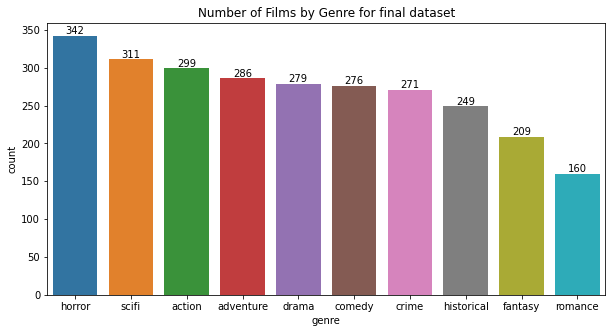

In [ ]:
plt.figure(figsize = (10,5))
plt.title("Number of Films by Genre for final dataset")

ax = sns.countplot(x = 'genre', data = df,order=df['genre'].value_counts(ascending=False).index)
abs_values = df['genre'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

Let us now do a few quick checks on the dataset to understand how it looks 

In [ ]:
df.columns

Index(['genre', 'plot'], dtype='object')

In [ ]:
df.head(5)

,genre,plot
0,action,frank vega is a decorated vietnam war veteran ...
1,action,journalist matt nashs dylan walsh investigatio...
2,action,in the midtolate 1960s three young men leave t...
3,action,po sing the youngest son of chinese triad boss...
4,action,clay santell audie murphy has his horse stolen...


Let us explore the length of the plots in each genre and observe the number of stopwords in each section. This will help us understand if the data we have collected for each genre is inherently different. If basic linguistic characteristics such as the length of the plots are different, we could find that the representations we use (later) might not work the same way for all.

<AxesSubplot:title={'center':'Box plot analysis of Genre by stopwords count'}, xlabel='stopwords_count', ylabel='genre'>

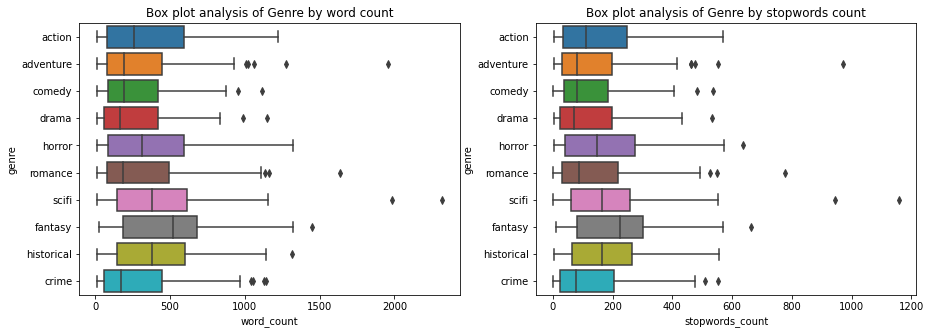

In [ ]:
def stop_and_total_words_and_proportion_counter(dataframe_text_col):
    '''
    params: dataframe column / np array / list
    returns: (1) a list of elements for counts on # of stopwords in a sentence
             (2) a list of elements for counts on # of words in a sentence
             (3) a list of elements for (1)/(2) of each sentence
    '''
    total_time_taken = 0
    count_list_sw = []
    count_list_total = []
    proportion_of_stopwords = []
    count_sentence = 0
    stop_words = nltk.corpus.stopwords.words('english')
    for sentence in dataframe_text_col:
        start_time = time.time()
        tokenized = word_tokenize(sentence)
        # print(tokenized)
        count_stop_words = 0
        count_total_words = 0
        for word in tokenized:
            count_total_words +=1
            # print(F'Total word: {word} | {count_total_words}')
            if word in stop_words:
                count_stop_words +=1
                # print(f'Stop word: {word} | {count_stop_words}')
            else:
                count_stop_words = count_stop_words
        time_taken_per_sentence = time.time() - start_time
        total_time_taken += time_taken_per_sentence
        count_list_sw.append(count_stop_words)
        count_list_total.append(count_total_words)
        proportion_of_stopwords.append(count_stop_words/count_total_words)
        count_sentence +=1
        if count_sentence % 10000 == 0:
            print(f'#SENTENCE READ: {count_sentence} | time taken per sentence: {time_taken_per_sentence:.2f} second(s) | overall time taken: {total_time_taken/60:.2f} minute(s)')
    return count_list_sw , count_list_total , proportion_of_stopwords


# Computing stopwords count, plot length, and proportion of stopwords to plot length for each plot
df['stopwords_count'], df['word_count'], df['proportion_of_stopwords_to_wordcount'] = stop_and_total_words_and_proportion_counter(df['plot'])
df['proportion_of_stopwords_to_wordcount'] = df['proportion_of_stopwords_to_wordcount'].map('{:,.3f}'.format)
df['proportion_of_stopwords_to_wordcount'] = df["proportion_of_stopwords_to_wordcount"].apply(lambda x: float(x))

# 1st visual: distribution of genre by plot_length
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Box plot analysis of Genre by word count')
sns.boxplot(x = 'word_count', y='genre', data=df)

# 2nd visual: distribution of genre by stopwords_count
plt.subplot(1,2,2)
plt.title('Box plot analysis of Genre by stopwords count')
sns.boxplot(x = 'stopwords_count', y='genre', data=df)

We see some variation in the mean word_count shown below. Here we are looking at the average statistics per genre, and we are seeing that some genre's like "fantasy" and "scifi" have much longer plot summaries. 

Since wikipedia's data is crowdsourced, it is possible that human factors involving the contributors to the two categories impact the difference, rather than any statistically significant information about then genre. To get a better picture we look at the full statistics of the word_count column.

As expected from crowd sourced data, we observe:

1.  High standard deviation in the word count, which means that we see high variance around the mean. This means that our dataset is not consistent in the text format. However, data quality is not in our control, and it comes at the compromise of data volume.

2.  The 50th percentile (a more resillient measure than mean when subject to outliers), is to the left of the mean, indicating that some very long plots have pulled the mean to the right.

In [ ]:
# We calculate the mean of world_count for each genre
df.groupby('genre').mean().reset_index()

,genre,stopwords_count,word_count,proportion_of_stopwords_to_wordcount
0,action,147.772575,343.775920,0.424579
1,adventure,129.202797,294.482517,0.429490
2,comedy,120.148551,269.739130,0.435217
3,crime,124.280443,281.099631,0.431417
4,drama,119.562724,268.333333,0.436312
5,fantasy,204.229665,457.889952,0.442215
6,historical,172.594378,398.417671,0.428506
7,horror,165.695906,367.871345,0.446310
8,romance,136.906250,303.525000,0.439687
9,scifi,175.996785,401.456592,0.431585


In [ ]:
# summary statistics of word counts
print(df['word_count'].describe())

count    2682.000000
mean      338.044743
std       281.847043
min        10.000000
25%        87.000000
50%       256.000000
75%       567.750000
max      2321.000000
Name: word_count, dtype: float64


Looking further at the distribution of the word count, we have the following histogram.

A quick look tells us that:

1. Adventure is skewed towards short plots
2. Scifi is skewed towards long plots (>500 words)
3. Other genres seem to follow a closer distribution.

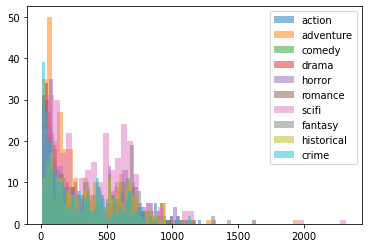

In [ ]:
# Distribution of the word count per genre
from matplotlib import pyplot

for genre in df['genre'].unique().tolist():
  x = df[df['genre']==genre].word_count

  pyplot.hist(x, bins=50, alpha=0.5, label=genre)
  
pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
# We drop the analytics columns before proceeding to the model phase
df.drop(columns=['stopwords_count', 'word_count', 'proportion_of_stopwords_to_wordcount'],axis=1,inplace=True)
df.columns

Index(['genre', 'plot'], dtype='object')

# Traditional ML

Reference for this section: [Paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3547887)

As this is the baseline for our project, we **use an existing implementation from this paper for this section** provided by this paper and accompanying tutorial, and we use this for this section on Traditional ML. The code-cells are hidden by default as they are not the focus.

  ### TF-IDF based vectorization

In [ ]:
# Later in the last section we implement our TF-IDF, but we start with the 
# implemented one.
# We convert the text plot into a vector using the TF-IDF scores
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Shuffle 
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
stopwords = list(set(stopwords.words('english')))

X = df['plot']
Y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],          
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [0.3, 0.5],
              'vect__max_features': [None, 1000],                                          
              'clf__n_estimators': [100, 200],
              'clf__learning_rate': [0.001, 0.01]
              }

tree = DecisionTreeClassifier(max_depth=5)

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', AdaBoostClassifier(base_estimator=tree))]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=3, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=cv, 
                           n_jobs=1, verbose=2)

gs_lr_tfidf.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END clf__learning_rate=0.001, clf__n_estimators=100, vect__max_df=0.3, vect__max_features=None, vect__ngram_range=(1, 1), vect__stop_words=['if', 'doing', 'from', "haven't", 'off', 'only', "weren't", 'of', 'then', "you're", 'weren', 'through', 'hasn', 'theirs', 'having', "don't", 'not', 'down', 'all', 'me', 'once', 'those', 'how', 'more', 'wouldn', "you've", "wasn't", 'she', 'to', 'we', 'which', 're', 'same', 'this', 'by', 'when', "needn't", "hasn't", 'as', 'been', 'hadn', 'own', 'y', 'mustn', "couldn't", 'too', 's', 'so', 'their', 'did', "it's", 'the', "mustn't", "aren't", 'both', 'can', 'hers', 'haven', 'ain', 'now', 'they', 'who', 'nor', 'just', 'should', 'don', "mightn't", 'our', 'out', "didn't", 'was', 'didn', 'are', 'o', 'doesn', "you'd", 'its', 'with', 'an', "doesn't", 'yourselves', 'his', 'against', 'why', 'again', 'under', 'mightn', 'up', 'does', 'about', 'were', 'into', 'he', 'll', 'is', 'be', 'wasn', "wouldn't

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5)))]),
             n_jobs=1,
             param_grid={'clf__learning_rate': [0.001, 0.01],
                         'clf__n_estimators': [100, 200],
                         'vect__max_df': [0.3, 0.5],
                         'vect__max_features': [None, 1000],
                         'vect__ngram_range': [(1, 1)],
                         'vect__stop_words': [['if', 'doing', 'from', "haven't",
                                               'off', 'only', "weren't", 'of',
                                               'then', "you're", 'weren',
                                               'through', 'hasn', 'theirs',
             

In [ ]:
# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################


print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('Test Accuracy: %.3f' % acc)

Best parameter set: {'clf__learning_rate': 0.01, 'clf__n_estimators': 200, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__ngram_range': (1, 1), 'vect__stop_words': ['if', 'doing', 'from', "haven't", 'off', 'only', "weren't", 'of', 'then', "you're", 'weren', 'through', 'hasn', 'theirs', 'having', "don't", 'not', 'down', 'all', 'me', 'once', 'those', 'how', 'more', 'wouldn', "you've", "wasn't", 'she', 'to', 'we', 'which', 're', 'same', 'this', 'by', 'when', "needn't", "hasn't", 'as', 'been', 'hadn', 'own', 'y', 'mustn', "couldn't", 'too', 's', 'so', 'their', 'did', "it's", 'the', "mustn't", "aren't", 'both', 'can', 'hers', 'haven', 'ain', 'now', 'they', 'who', 'nor', 'just', 'should', 'don', "mightn't", 'our', 'out', "didn't", 'was', 'didn', 'are', 'o', 'doesn', "you'd", 'its', 'with', 'an', "doesn't", 'yourselves', 'his', 'against', 'why', 'again', 'under', 'mightn', 'up', 'does', 'about', 'were', 'into', 'he', 'll', 'is', 'be', 'wasn', "wouldn't", 'it', 'what', 'and', 'my', 'n

### Part of speech based models


In [ ]:
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

def pos_tags(text):
    text_processed = word_tokenize(text)
    return "-".join( tag for (word, tag) in nltk.pos_tag(text_processed))

pos_tags(df.loc[0, 'plot'])

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df['text_pos']=df.apply(lambda x: pos_tags(x['plot']), axis=1)
X = df['text_pos']
Y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],               # we consider only 1-gram POS (for 2-grams: (1,2))
              'clf__n_estimators': [100, 200, 400],
              'clf__learning_rate': [0.001, 0.01, 1.0]}

tree = DecisionTreeClassifier(max_depth=5)

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', AdaBoostClassifier(base_estimator=tree))]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=3, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=cv, 
                           n_jobs=1, verbose=2)

gs_lr_tfidf.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END clf__learning_rate=0.001, clf__n_estimators=100, vect__ngram_range=(1, 1); total time=   4.0s
[CV] END clf__learning_rate=0.001, clf__n_estimators=100, vect__ngram_range=(1, 1); total time=   3.1s
[CV] END clf__learning_rate=0.001, clf__n_estimators=100, vect__ngram_range=(1, 1); total time=   3.7s
[CV] END clf__learning_rate=0.001, clf__n_estimators=200, vect__ngram_range=(1, 1); total time=   6.6s
[CV] END clf__learning_rate=0.001, clf__n_estimators=200, vect__ngram_range=(1, 1); total time=   5.7s
[CV] END clf__learning_rate=0.001, clf__n_estimators=200, vect__ngram_range=(1, 1); total time=   5.7s
[CV] END clf__learning_rate=0.001, clf__n_estimators=400, vect__ngram_range=(1, 1); total time=  10.9s
[CV] END clf__learning_rate=0.001, clf__n_estimators=400, vect__ngram_range=(1, 1); total time=  11.0s
[CV] END clf__learning_rate=0.001, clf__n_estimators=400, vect__ngram_range=(1, 1); total time=  10.9s
[CV] END clf_

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5)))]),
             n_jobs=1,
             param_grid={'clf__learning_rate': [0.001, 0.01, 1.0],
                         'clf__n_estimators': [100, 200, 400],
                         'vect__ngram_range': [(1, 1)]},
             scoring='accuracy', verbose=2)

In [ ]:
# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################


print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('Test Accuracy: %.3f' % acc)

Best parameter set: {'clf__learning_rate': 1.0, 'clf__n_estimators': 400, 'vect__ngram_range': (1, 1)} 
Test Accuracy: 0.209


### Word embeddings based models


In [ ]:
!python -m spacy download en_core_web_md

import spacy
nlp = spacy.load('en_core_web_md') 

# Shuffle
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

emb = np.vstack(df['plot'].apply(lambda x: nlp(x).vector))
X = emb
Y = df['genre']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'clf__n_estimators': [100, 250, 400],
              'clf__learning_rate': [0.001, 0.01]}

tree = DecisionTreeClassifier(max_depth=5)

pipe = Pipeline([('clf', AdaBoostClassifier(base_estimator=tree))])

# on cross-validation parameters
cv = StratifiedKFold(n_splits=3, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(pipe, param_grid,
                           scoring='accuracy',
                           cv=cv, 
                           n_jobs=1, verbose=2)                       
# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

2022-11-16 11:53:12.411624: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 283 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ....clf__learning_rate=0.001, clf__n_estimators=100; total time=  26.3s
[CV] END ....clf__learning_rate=0.001, clf__n_estimators=100; total time=  28.5s
[CV] END ....clf__learning_rate=0.001, clf__n_estimators=100; total time=  29.9s
[CV] END ....clf__learning_rate=0.001, clf__n_estimators=250; total time= 1.1min
[CV] END ....clf__learning_rate=0.001, clf__n_estimators=250; total time= 1.1min
[CV] END ....clf__learning_rate=0.001, clf__n_estimators=250; total time= 1.1min
[CV] END ....clf__learning_rate=0.

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('clf',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5)))]),
             n_jobs=1,
             param_grid={'clf__learning_rate': [0.001, 0.01],
                         'clf__n_estimators': [100, 250, 400]},
             scoring='accuracy', verbose=2)

In [ ]:
# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)


# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################


print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)

print('Test Accuracy: %.3f' % acc)

Best parameter set: {'clf__learning_rate': 0.01, 'clf__n_estimators': 400} 
Test Accuracy: 0.339


# Deep Learning 1: Multi-Layer Perceptron (MLP)

This section has functionality implemented from scratch!

In this section we aim to achieve the following objectives: 

1. Explore word embeddings to transform text plots into vectors 
2. Create a framework that is capable of running a large number of experiments with configurable parameters including both basic and complex configurations

    - Epochs 
    - Model architecture (types of layers, parameters to layers, etc.)
    - Learning rate
    - Down/up-sampling dataset
    - Model checkpointing 
    - Word embedding dimension
    - Batch size
    - Source data
    - Sentence embedding strategy (simple mean / tf-idf weighted mean)
    - Text cleaning strategy
3. Run experiments with different parameters to identify the best parameter set.
4. Display analytics for the classification problem




### Utility functions 




Define common classes including a SentCleaner, which implements tokenization, lower casing, stop word removal, punctuation and escape removal. 

Pre-processing text is vital to Natural Languauge Processing (NLP) tasks. We perform the following pre-processing steps:

1. Tokenization: Splitting a sentence into separate tokens which are words. These words are then processed further.
2. Lower casing: Lower case all the words to standardize them
3. Stop word removal: Most sentences contain a lot of common words from the language which are not significant to the meaning of the sentence, but required for gramatical correctness. 
For example, articles like 'a' and 'the' are sometimes important to the meaning (e.g., "the reason I study.." vs "a reason I study.." imply a differnece in cardinality of the reasons), but in the vast majority of cases are used because articles are required to identify the noun being referred to. 
While using with word embeddings in the averaging fashion, we remove stop words to make the dataset size more manageable.



In [ ]:
from nltk.corpus import stopwords
# Define some utils classes and methods

"""
Read configs from file for defining training
"""
def get_configs(config_file="config.json"):
    with open(config_file, 'r') as fp:
        return json.load(fp)["configs"]

"""
Create default text cleaning config
"""
def get_default_sent_cleaner_conf():
    # Sentence cleaner conf
    sent_cleaner_conf = dict()
    sent_cleaner_conf['token'] = True
    sent_cleaner_conf['lower'] = True
    sent_cleaner_conf['encode'] = False
    sent_cleaner_conf['remove_stop'] = True
    sent_cleaner_conf['remove_punc'] = True
    sent_cleaner_conf['remove_esc'] = True
    sent_cleaner_conf['stem'] = False

    return sent_cleaner_conf

"""
Create default text cleaning config
"""
def get_default_sent_cleaner_conf_all_false():
    # Sentence cleaner conf
    sent_cleaner_conf = dict()
    sent_cleaner_conf['token'] = True
    sent_cleaner_conf['lower'] = False
    sent_cleaner_conf['encode'] = False
    sent_cleaner_conf['remove_stop'] = False
    sent_cleaner_conf['remove_punc'] = False
    sent_cleaner_conf['remove_esc'] = False
    sent_cleaner_conf['stem'] = False

    return sent_cleaner_conf

"""
Create default down-sampling config
"""
# Set up default conf
def get_default_down_sample_conf():
    # Down sample conf
    down_sample_conf = dict()

    for genre in FILMS_GENRE:
        down_sample_conf[genre] = 0

    return down_sample_conf


"""
Simple logger to write training outputs to 
training log file
"""
class Logger:
    def __init__(self, output_dir, file_name, class_name):
        self.output_dir = output_dir
        self.file_name = file_name
        self.class_name = class_name
        self.fp = open(os.path.join(self.output_dir, file_name), "a+")

    def log(self, to_log):
        now = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        self.fp.write(f"{now}: {to_log}\n")
        self.fp.flush()

    def close(self):
        self.fp.close()


"""
Implement text cleaning in a simple cleaner class
"""
class SentCleaner:
    def __init__(self, sent, conf):
        self.sent = sent
        self.sent_tokenized = None
        self.conf = conf

    def lower_case(self):
        if self.conf['lower']:
            self.sent = self.sent.lower()
        return self

    def tokenize(self):
        if self.conf['token']:
            self.sent_tokenized = word_tokenize(self.sent)
        return self

    def remove_stopwords(self, stop_words):
        if self.conf['remove_stop']:
            self.sent_tokenized = [word for word in self.sent_tokenized if word not in stop_words]
        return self

    def remove_punct(self):
        if self.conf['remove_punc']:
            self.sent_tokenized = [word for word in self.sent_tokenized if re.search('[a-z]', word)]
        return self

    def stem_words(self):
        if self.conf['stem']:
            stemmer = PorterStemmer()
            self.sent_tokenized = [stemmer.stem(word) for word in self.sent_tokenized]
        return self

    def remove_escapes(self):
        if self.conf['remove_esc']:
            stripped = [word.replace('\n', '') for word in self.sent_tokenized]
            self.sent_tokenized = [word for word in stripped if word != '']
        return self

    def clean_sent(self):
        self.lower_case() \
            .tokenize() \
            .remove_punct() \
            .remove_escapes() \
            .stem_words() \
            .remove_stopwords(stopwords.words('english'))

        return self.sent_tokenized

    def sent_v(self):
        return set(self.sent_tokenized)

### Analytics

We now define some basic analytics that are suitable to the classification problem, so that we can visualize the results once we have completed training. 

We set up the following plots and analytics to help us interpret the results:

1. Confusion matrix: A confusion matrix helps visualise the propensity of the matrix to make every kind of classification error ("confusion"), and numerically shows in the matrix how many times each combination of error was made. The diagonal of the matrix contains the counts of the correct classification, and so what we expect to see is that as training proceeds, the values along the diagonal will grow.

2. Loss plot: As a model is trained, we can check validation loss to understand how the model is generalising. This validation loss serves to let us know when we are over fitting to the training set. The test loss on the other hand is only seen after we have already picked the model to evaluate. We do not use this for model selection.

3. Training and test statistics: Once we have split the dataset into the train, validation and test splits, we check to see the distribution of the training examples in each class. If any of those is heavily skewed in one direction, we could end up with a bad training run that does not generalise.

4. Accuracy by class: As an extension of the confusion matrix, it is important for us to understand how well a model is doing in each class. It is very important to understand if it is classifying one class well, and another poorly, as it helps us guide future directions. Additionally, real world applications of models are often not possible in production unless there is a guarantee of a minimum performance on all classes. Hence, we look at this plot.

In [ ]:
"""
Analytics and visualization for classification 
problems
"""
class Analytics:

    @staticmethod
    def confusion_matrix_analysis(Y_shuffled, Y_preds, model_name, epoch):
        Analytics.create_dirs_if_not_present(model_name)
        os.makedirs(f"/content/outputs/{model_name}/confusion/", exist_ok=True)

        plt.clf()
        conf_mat = confusion_matrix(Y_shuffled, Y_preds)

        # Normalise the array
        highest, lowest = np.max(conf_mat), np.min(conf_mat)
        value_range = highest - lowest
        conf_mat = conf_mat * (1.0 / value_range)

        # Plot a heat map
        ax = sns.heatmap(conf_mat, linewidths=0.3, xticklabels=FILMS_GENRE, yticklabels=FILMS_GENRE)
        ax.set(title=f'Confusion at epoch: {epoch}')
        ax.figure.savefig(f"/content/outputs/{model_name}/confusion/{epoch}.png")
        plt.clf()

    @staticmethod
    def create_animated_gifs(model_name):
        Analytics.create_dirs_if_not_present(model_name)
        sort_fn = lambda x: int(os.path.basename(x).split('/')[-1].split('.')[0])
        images = [Image.open(image) for image in sorted(glob.glob(f"/content/outputs/{model_name}/confusion/*.png"), key=sort_fn)]
        images[0].save(f"/content/outputs/{model_name}/confusion/confusion.gif", format="GIF", append_images=images,
                       save_all=True, duration=len(images) / 2, loop=0)

    @staticmethod
    def plot_loss(train_loss, val_loss, model_name):
        Analytics.create_dirs_if_not_present(model_name)
        plt.clf()
        epochs = np.arange(len(train_loss))
        plt.title("Training and Validation Loss")
        plt.plot(epochs, train_loss, label="Train Loss")
        plt.plot(epochs, val_loss, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"outputs/{model_name}/loss.png")
        plt.show()
        plt.clf()

    @staticmethod
    def plot_acc(train_acc, val_acc, model_name):
        Analytics.create_dirs_if_not_present(model_name)
        plt.clf()
        epochs = np.arange(len(train_acc))
        plt.title("Training and Validation Acc")
        plt.plot(epochs, train_acc, label="Train Acc")
        plt.plot(epochs, val_acc, label="Validation Acc")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(f"outputs/{model_name}/loss.png")
        plt.clf()

    @staticmethod
    def show_train_val_test_stats(y_train, y_test, y_val, logger):
        ytr, yva, yte = np.array(y_train).astype(int), np.array(y_val).astype(int), np.array(y_test).astype(int)
        logger.log("Train statistics")
        logger.log(np.unique(ytr, return_counts=True))
        logger.log("Validation statistics")
        logger.log(np.unique(yva, return_counts=True))
        logger.log("Test statistics")
        logger.log(np.unique(yte, return_counts=True))

    @staticmethod
    def acc_by_class(Y_shuffled, Y_preds, model_name, epoch_num):
        os.makedirs(f"/content/outputs/{model_name}/acc_by_class/", exist_ok=True)
        Analytics.create_dirs_if_not_present(model_name)
        truth = np.array(Y_shuffled, dtype=int).reshape(-1)
        preds = np.array(Y_preds, dtype=int)

        is_correct = (truth == preds).astype(int)

        accuracies = []

        for cat in range(len(FILMS_GENRE)):
            ind = np.where(truth == cat)
            total = len(ind[0]) + 1e-8
            correct = np.sum(is_correct[ind[0]])

            accuracies.append(correct / total)

        plt.clf()
        plt.title(f"Accuracies by class - epoch-{epoch_num}")
        plt.barh(FILMS_GENRE, accuracies)
        plt.xlabel("Classes")
        plt.ylabel("Accuracy")
        plt.savefig(f"outputs/{model_name}/acc_by_class/{epoch_num}.png")
        plt.clf()
        return accuracies

    @staticmethod
    def plot_value_counts(df: pd.DataFrame, model_name, split):
        Analytics.create_dirs_if_not_present(model_name)
        plt.clf()
        plt.title("Frequencies by class")
        plt.xlabel("Frequency")
        plt.ylabel("Classes")
        df['genre'].value_counts().plot(kind="barh")
        plt.savefig(f"/content/outputs/{model_name}/{split}_value_counts.png", bbox_inches="tight")
        plt.clf()

    @staticmethod
    def create_dirs_if_not_present(model_name):
        os.makedirs(f"/content/outputs/{model_name}", exist_ok=True)

    """
    Sanity checks on visualization
    """
    
    @staticmethod
    def test_confusion():
        a = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

        for i in range(10):
            b = [i] * 10
            Analytics.confusion_matrix_analysis(a, b, "test", i)
        Analytics.create_animated_gifs("test")

    @staticmethod
    def test_loss():
        a = [1] * 1000
        b = [2] * 1000
        Analytics.plot_loss(a, b, "test")

    @staticmethod
    def test_value_counts():
        df = pd.DataFrame(columns=["genre"], data=[["drama"], ["comedy"], ["comedy"]])
        Analytics.plot_value_counts(df, "test")

  ### Word embeddings and TF-IDF

We now implement TF-IDF from scratch. Term-frequency-Inverse Document Frequency is a fundamental and basic concept in NLP that basically serves help us vectorise a sentence by using statistics of the occurence of the words in each document vs the number of documents they occur in. The concept is summarised as:

1. Good terms occur very often in a specific document, but they occur rarely across the dataset. This means this term will get a high score for containing valuable information about this document.

2. Terms that occur in almost every document are not very valuable in understanding the difference between different documents. These terms will receive a low score even if their term frequency is high, as the inverse document frequency will pull it down to a small score. These are often the stop words.



In [ ]:
"""
Implement basic tf-idf from scratch
"""
class TfIdfWeighter:
    def __init__(self, cleaned_plots):
        self.plots = cleaned_plots
        self.n = len(self.plots)
        l = max([len(pl) for pl in self.plots])
        self.tf_idf = np.zeros((self.n, l))
        self.vocab = set()
        self._set_vocab()

    def calc_tf(self):
        for i, plot in enumerate(self.plots):
            _v = {}
            for word in plot:
                _v[word] = _v.get(word, 0) + 1

            for j, word in enumerate(plot):
                self.tf_idf[i, j] = _v.get(word, 0)

    def _set_vocab(self):
        for plot in self.plots:
            for word in plot:
                self.vocab.add(word)

    def get_tf_idf(self):
        self.calc_tf()
        word_sets = [set(plot) for plot in self.plots]
        idf = {}
        for word in self.vocab:
            fn = lambda _w, _s: 1 if _w in _s else 0
            df = sum([fn(word, word_set) for word_set in word_sets])
            idf[word] = math.log(self.n / (1 + df))

        for i, plot in enumerate(self.plots):
            for j, word in enumerate(plot):
                self.tf_idf[i, j] *= (idf.get(word, 0))

        return self.tf_idf

The use of word embeddings is more modern approach to NLP. We use pre-trained word vector representations to load vectors for each word that capture their meaning in some form. Word-embeddings are often trained on different corpora with different techniques, and the final models are provided to be used as pre-trained vectors.

If we had a large enough dataset, we could also train our own embeddings. In our case, there are already pre-trained embeddings trained on the wikipedia dataset, so we use those embeddings out of the box. We explore:

- glove (50, 100, 300 dimension)
- word2vec (300 dimension, trained on google news)
- fasttext

This class helps load the word embeddings for use. The highlight of this class is that it can 

- load embeddings as required by the configuration automatically
- calculate sentence embeddings from word embeddings using a simple average
- calculate TF-IDF weighted word embeddings to help prioritise important words in the mean vector (sentence embedding)



In [ ]:
"""
Embedding loader to help load different embeddings
from gensim, and apply them on the data frame in 
different ways
"""
class EmbeddingLoader:
    def __init__(self, embedding_name: str, logger):
        self.logger = logger
        self.embeddings = api.load(embedding_name)

    def embed(self, sentence):
        valid_words = [word for word in sentence if word in self.embeddings.key_to_index]
        # embedded = [self.embeddings[word] for word in valid_words]
        embedded = []
        for word in sentence:
            if word in self.embeddings.key_to_index:
                embedded.append(self.embeddings[word])
            else:
                embedded.append(np.zeros_like(self.embeddings['hello']))

        embedded = np.array(embedded)
        hit_rate = len(valid_words)/len(sentence)
        self.logger.log (f"Dimension of embedded array: {embedded.shape}, hit rate: {hit_rate}")
        return embedded, hit_rate

    def get_mean(self, sentence):
        valid_words = [word for word in sentence if word in self.embeddings.key_to_index]
        hit_rate = len(valid_words)/len(sentence)
        self.logger.log(f"Hit rate: {hit_rate}")
        return self.embeddings.get_mean_vector(valid_words)

    def get_tf_idf_weighted_mean(self, all_plots, tf_idf_vecs):
        vec_rep = []
        total_hit_rate = 0
        for i, plot in enumerate(all_plots):
            scores = tf_idf_vecs[i, :len(plot)]
            vectors, hit_rate = self.embed(plot)
            total_hit_rate += hit_rate
            self.logger.log(f"Hit rate: {hit_rate}")
            self.logger.log(f"Vectors shape: {vectors.shape}")

            n_vecs = vectors.shape[0]
            assert len(scores) == n_vecs
            weighted_mean = torch.zeros(vectors[0].shape)
            for j in range(n_vecs):
                weighted_mean = weighted_mean + (scores[j] * vectors[j])

            vec_rep.append(np.array(weighted_mean))

        self.logger.log(f"Overall hit rate: {total_hit_rate/len(all_plots)}")
        return torch.tensor(np.array(vec_rep))


We are now ready to apply the concepts to the dataset, so we wrap the dataset with a reader class that reads the source dataset and performs the following transformations:

- Applying sentence cleaning 
- Applying down sampling on each class if configured
- Transforming sentence to embeddings using TF-IDF or simple average

In [ ]:
"""
Dataset reader to read the dataset from file
and perform transformations (vectorization)
on the source data
"""
class DatasetReader:
    def __init__(self, embedding_type, logger, sent_cleaner_conf=None, down_sample_conf=None):
        if sent_cleaner_conf is None:
            sent_cleaner_conf = get_default_sent_cleaner_conf()
        if down_sample_conf is None:
            down_sample_conf = get_default_down_sample_conf()

        # Member assignments
        self.logger = logger
        self.embedding_loader = EmbeddingLoader(embedding_type, logger)
        self.sent_cleaner_conf = sent_cleaner_conf
        self.down_sample_conf = down_sample_conf

    def read(self, path_to_zip, simple, model_name):
        # Reading from zip files, and storing in a dictionary with key is fim genre,
        # and value is list of films with plot
        initial_df = pd.DataFrame()

        with zipfile.ZipFile(path_to_zip) as z:
            for name in z.namelist():
                if name.endswith(".csv"):
                    self.logger.log(f'Loading data from {name}...')
                    x = pd.read_csv(z.open(name))
                    self.logger.log(f'Loading completed from {name}...')
                    initial_df = pd.concat([initial_df, x[['genre', 'plot']]], axis=0, ignore_index=True)
            self.logger.log("Dataframe (df) ready to be used!")

        df = self._down_sample(initial_df)
        df = df.dropna()

        # Shuffle the df
        df = df.sample(frac=1)

        self.logger.log(df['genre'].value_counts())
        Analytics.plot_value_counts(df, model_name, "full")
        if simple:
            self.logger.log("Preparing vectors using simple average")
            return self._prepare_dataset(df)
        else:
            self.logger.log("Preparing vectors using weighted TF-IDF average")
            return self._prepare_dataset_tfidf(df)

    def _down_sample(self, df):
        # Down sample drama
        for genre in FILMS_GENRE:
            sample_percent = self.down_sample_conf.get(genre, 0.0)
            df = df.drop(df.query(f"genre == '{genre}'").sample(frac=sample_percent).index)

        self.logger.log(df['genre'].value_counts())
        return df

    def _prepare_dataset(self, df):
        # Clean the plots
        cleaned_plots = df['plot'].apply(lambda x: SentCleaner(x, self.sent_cleaner_conf).clean_sent())
        # Create the mean embedding vector
        embed_vectors = torch.tensor(np.array([self.embedding_loader.get_mean(plot) for plot in list(cleaned_plots)]))
        X = embed_vectors
        self.logger.log (f"Mean vector result shape (embed_vectors) for {len(cleaned_plots)} plots: {embed_vectors.shape}")

        Y = torch.tensor(np.array(df['genre'].apply(lambda g: TARGET_LKP[g])))

        self.logger.log(f"Shape of X: {X.shape}")
        self.logger.log(f"Shape of Y: {Y.shape}")

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        Analytics.show_train_val_test_stats(y_train, y_val, y_test, self.logger)

        return X_train, X_test, y_train, y_test, X_val, y_val

    # Limitation: separate tfidf for test set
    def _prepare_dataset_tfidf(self, df):
        # Clean the plots
        cleaned_plots = df['plot'].apply(lambda x: SentCleaner(x, self.sent_cleaner_conf).clean_sent())

        # Calculate TFIDF
        tf_idf_vecs = TfIdfWeighter(cleaned_plots).get_tf_idf()
        embed_vectors = self.embedding_loader.get_tf_idf_weighted_mean(cleaned_plots, tf_idf_vecs)

        X = embed_vectors
        self.logger.log (f"Mean vector result shape (embed_vectors) for {len(cleaned_plots)} plots: {embed_vectors.shape}")
        Y = torch.tensor(np.array(df['genre'].apply(lambda g: TARGET_LKP[g])))

        self.logger.log(f"Shape of X: {X.shape}")
        self.logger.log(f"Shape of Y: {Y.shape}")

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        Analytics.show_train_val_test_stats(y_train, y_val, y_test, self.logger)

        return X_train, X_test, y_train, y_test, X_val, y_val



## Model framework

The final remaining step is to create the models that we want to train on this dataset. As we would like to experiment with a lot of models, it is not practical to define them over and over. 

In this section we implement model structure parsing to help parse a model from its configuration.

This framework parses the model structure from the configurations. For example, it takes ['l_50_100', 'r', 'd_0.5', ..] and creates a linear layer from 50 - 100 units, followed by relu and a dropout layer with probability 0.5.


In [ ]:
"""
Framework to automatically parse a MLP model 
from a text configuration
"""
class ModelSpecParser:
    def __init__(self, spec, dim):
        self.dim = dim
        self.seq = None
        self.parse(spec)
        summary(self.seq, (1, dim))

    def parse(self, spec):
        self.seq = nn.Sequential()
        _seq = []

        for layer in spec:
            parts = layer.split('_')

            if parts[0] == 'l':
                # Linear layer
                assert len(parts) == 3
                _seq.append(nn.Linear(int(parts[1]), int(parts[2])))
            elif parts[0] == 'd':
                # Dropout layer
                assert len(parts) == 2
                _seq.append(nn.Dropout(p=float(parts[1])))
            elif parts[0] == 's':
                # Softmax layer
                assert len(parts) == 2
                _seq.append(nn.Softmax(dim=int(parts[1])))
            elif parts[0] == 'r':
                # ReLU layer
                assert len(parts) == 1
                _seq.append(nn.ReLU())
            elif parts[0] == 'bn':
                assert len(parts) == 2
                _seq.append(nn.B)

        self.seq = nn.Sequential(*_seq)

We now wrap the basic functionality over nn.Module and build our model on top of this. We implement the following features here:

- Checkpointing (as an alternative to early stopping)
- Forward, loss and backward
- Analytics during training
- Collect metrics on the training itself

In [ ]:
"""
Wrap basic model parsing functionality in a 
basic deep learning model class
"""
class BasicDeepLearner(nn.Module):
    def __init__(self, model_spec, alpha, input_dim):
        super().__init__()
        self.seq = ModelSpecParser(model_spec, input_dim).seq
        self.alpha = alpha

In [ ]:
"""
Implementation of simple MLP model training and testing
framework
"""

class SimpleMLPTextClassifier(BasicDeepLearner):
    def __init__(self, checkpoint_freq, loss_fn, model_spec, name, sent_cleaner_conf, device, input_dim, batch_size, logger, alpha=1e-4):
        super().__init__(model_spec, alpha, input_dim)
        self.logger = logger
        self.loss_fn = loss_fn
        self.alpha = alpha
        self.checkpoint_freq = checkpoint_freq
        self.name = name
        self.sent_cleaner_conf = sent_cleaner_conf
        self.device = device
        self.train_csv = open(f"outputs/{self.name}/train.csv", "w")
        self.metrics_csv = open(f"outputs/{self.name}/metrics.csv", "w")
        self.start_time = None
        self.end_time = None
        self.bs = batch_size

    def __init_csvs(self):
        self.train_csv.write("epoch,train_loss,val_loss,val_acc\n")
        self.metrics_csv.write("epoch,duration\n")

    def forward(self, X_batch):
        return self.seq(X_batch)

    def save_checkpoint(self, optimizer, curr_epoch, model_path, loss):
        self.logger.log(f"Saving checkpoint to {model_path}")
        torch.save({
            'epoch': curr_epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, model_path)

    def run_training(self, train_x, train_y, val_x, val_y, optim, epochs=10):
        # self.train()
        start_time = time.process_time()

        for e in range(0, epochs):
            _start = time.process_time()
            losses = self._training(train_x, train_y, optim)

            # Save model checkpoint
            mean_loss = torch.tensor(losses).mean()
            if e > 0 and e % self.checkpoint_freq == 0:
                os.makedirs(f"outputs/{self.name}/checkpoints", exist_ok=True)
                self.save_checkpoint(optim, e, f'outputs/{self.name}/checkpoints/epoch-{e}.pt', mean_loss)

            self.cal_loss_and_accuracy(val_x, val_y, mean_loss, e)

            _end = time.process_time()
            self.metrics_csv.write(f"{e},{_end-_start}\n")
            self.metrics_csv.flush()

        Analytics.create_animated_gifs(self.name)
        end_time = time.process_time()
        duration = end_time - start_time
        self.logger.log(f"Training time: {duration}")

    def _training(self, train_x, train_y, optim):
        losses = []
        # for X, Y in zip(torch.Tensor(train_x), torch.Tensor(train_y)):
        for row in range(0, train_x.shape[0], self.bs):
            X = train_x[row: row+self.bs]
            Y = train_y[row: row+self.bs]
            b = X.shape[0]
            Y_preds = self.forward(X)

            loss = self.loss_fn(Y_preds.view(b, 10), Y.view(b))
            losses.append(loss.item())

            optim.zero_grad()
            loss.backward()
            optim.step()

        return losses

    def cal_loss_and_accuracy(self, val_x, val_y, train_loss, epoch_num):
        with torch.no_grad():
            Y_shuffled, Y_preds, losses = [], [], []
            for i in range(val_x.shape[0]):
                X = val_x[i]
                Y = val_y[i]
                preds = self.forward(X)
                loss = self.loss_fn(preds.view(-1, 10), Y.view(1))
                losses.append(loss.item())

                Y_shuffled.append(Y.view(1))
                Y_preds.append(preds.argmax(dim=-1))

            Y_shuffled = torch.stack(Y_shuffled)
            Y_preds = torch.stack(Y_preds)

            # Check confusion matrix
            Analytics.confusion_matrix_analysis(Y_shuffled, Y_preds, self.name, epoch_num)

            # Check error by class
            Analytics.acc_by_class(Y_shuffled, Y_preds, self.name, epoch_num)

            self.train_csv.write(f"{epoch_num},{train_loss},{torch.tensor(losses).mean()},{accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())}\n")
            self.train_csv.flush()
            self.logger.log("Epoch: {:d} | Train Loss: {:.3f} | Valid Loss : {:.3f} | Valid Acc  : {:.3f}"
                            .format(epoch_num, train_loss, torch.tensor(losses).mean(),
                                    accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


### Experiments


Finally, we define a model run flow and error handling in case we decide to interrupt the model for any reason. If we decide to stop the training, it still evaluates it on the test set.

As this part takes a significant amount of time, we run it offline on a server and collect the results.

Here we run the experiments to show some results and collect the outputs.

In [ ]:
"""
Run a model from start to end with error handling
"""
IGNORE_VAL = 11.111

def run_model(structure, model_name, lr, epochs, input_dim, batch_size, logger, X_train, y_train, X_val, y_val, X_test, y_test):
    # Define and run the model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    loss_fn = nn.CrossEntropyLoss()
    model = SimpleMLPTextClassifier(checkpoint_freq=20, loss_fn=loss_fn,
                                    model_spec=structure, name=model_name,
                                    sent_cleaner_conf=None, device=device, input_dim=input_dim, batch_size=batch_size, logger=_logger, alpha=lr)
    try:
        optim = torch.optim.Adam(model.parameters(), lr=lr)
        model.run_training(X_train, y_train, X_val, y_val, optim, epochs=epochs)

        logger.log("Next line is test loss - ignore the train loss there")
        model.cal_loss_and_accuracy(X_test, y_test, IGNORE_VAL, 0)

        return 0
    except KeyboardInterrupt:
        logger.log('Stopped - Next line is test loss - ignore the train loss there')
        model.cal_loss_and_accuracy(X_test, y_test, IGNORE_VAL, 0)
        return 1

In [ ]:
"""
Configurations 
"""
# Fetch the configuration file that defines the experiments and begin
!rm config.json
!gdown 1tNu5VVyNMGWkD9BQtI29mqLM3pW7g-1t
!mkdir source_data 
!cp data_full3.zip source_data/ 

configs = get_configs("config.json")
print(f"Number of experiments: {len(configs)}")

LOGFILE = "training_log.txt"
OUTPUT_DIR = "/content/outputs"

for idx_config, config in enumerate(configs):
    try:
        print(f"Starting with model {idx_config}: {config['model_name']} with config:\n{config}")
        os.makedirs(f"outputs/{config['model_name']}", exist_ok=True)
        _logger = Logger(f"{OUTPUT_DIR}/{config['model_name']}", LOGFILE, "mlp_clf.py")

        dataset_reader = DatasetReader(config['embedding_type'], _logger)
        _X_train, _X_test, _y_train, _y_test, _X_val, _y_val = dataset_reader.read(config['data_path'], config['simple'], config['model_name'])
        outcome = run_model(config['structure'], config['model_name'], config['lr'], config['epochs'], config['input_dim'], config['batch_size'], _logger, _X_train, _y_train, _X_val, _y_val, _X_test, _y_test)

        if outcome == 0:
            _logger.log ("Completed training and testing")
        else:
            _logger.log ("Failed")
    except KeyboardInterrupt as ke:
        print("Interrupted - quitting")
        break
    except Exception as e:
        print("Failed the previous run. Trying the next")
        print (e)        

Downloading...
From: https://drive.google.com/uc?id=1tNu5VVyNMGWkD9BQtI29mqLM3pW7g-1t
To: /content/config.json
100% 8.77k/8.77k [00:00<00:00, 11.6MB/s]
Number of experiments: 17
Starting with model 0: first-model-batch-base with config:
{'data_path': 'source_data/data_full3.zip', 'model_name': 'first-model-batch-base', 'structure': ['l_50_125', 'd_0.3', 'r', 'l_125_125', 'd_0.3', 'r', 'l_125_150', 'd_0.3', 'r', 'l_150_110', 'd_0.3', 'r', 'l_110_75', 'l_75_10', 's_0'], 'lr': 0.0003, 'epochs': 250, 'input_dim': 50, 'batch_size': 16, 'simple': True, 'embedding_type': 'glove-wiki-gigaword-50', 'down_sample': {'drama': 0.0, 'comedy': 0.0}}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 125]           6,375
           Dropout-2               [-1, 1, 125]               0
              ReLU-3               [-1, 1, 125]               0
            Linear-4               [

<Figure size 432x288 with 0 Axes>

## Results and Analysis

The results are neatly produced so that we are able to share the results with others as required. The `outputs/` directory contains one directory per model, and contains the results in the structure:

-`outputs`
  - `{model_name}`
      - `checkpoints/` 
      - `confusion/`
      - `acc_by_class/`
      - `full_value_counts.png`
      - `metrics.csv`
      - `train.csv`
      - `training_log.txt`

These results can be used to understand the run fully after it has completed, and at each epoch the confusion and accuracies by class are stored. 

We look at the following results from one good run:



In [ ]:
# Let us zip the output directory so that it can be downloaded if desired
!zip -r outputs.zip /content/outputs

In [ ]:
# Let us view test loss from the 
!tail -5 /content/outputs/first-model-batch-base/training_log.txt

16/11/2022 00:20:46: Epoch: 199 | Train Loss: 2.070 | Valid Loss : 2.137 | Valid Acc  : 0.312
16/11/2022 00:20:49: Training time: 195.5436655200001
16/11/2022 00:20:49: Next line is test loss - ignore the train loss there
16/11/2022 00:20:49: Epoch: 0 | Train Loss: 11.111 | Valid Loss : 2.109 | Valid Acc  : 0.341
16/11/2022 00:20:49: Completed training and testing


In [ ]:
# Let us see the checkpoints and the accuracies
print ("Contents of the output directory")
!ls -lrt /content/outputs/first-model-batch-base
!ls -lrt /content/outputs/first-model-batch-base/checkpoints

Contents of the output directory
total 196
-rw-r--r-- 1 root root   9631 Nov 16 00:17 full_value_counts.png
drwxr-xr-x 2 root root   4096 Nov 16 00:20 checkpoints
drwxr-xr-x 2 root root   4096 Nov 16 00:20 acc_by_class
-rw-r--r-- 1 root root   4461 Nov 16 00:20 metrics.csv
drwxr-xr-x 2 root root   4096 Nov 16 00:20 confusion
-rw-r--r-- 1 root root  12001 Nov 16 00:20 train.csv
-rw-r--r-- 1 root root 152561 Nov 16 00:20 training_log.txt
total 7164
-rw-r--r-- 1 root root 812882 Nov 16 00:17 epoch-20.pt
-rw-r--r-- 1 root root 812882 Nov 16 00:17 epoch-40.pt
-rw-r--r-- 1 root root 812882 Nov 16 00:18 epoch-60.pt
-rw-r--r-- 1 root root 812882 Nov 16 00:18 epoch-80.pt
-rw-r--r-- 1 root root 812882 Nov 16 00:18 epoch-100.pt
-rw-r--r-- 1 root root 812882 Nov 16 00:19 epoch-120.pt
-rw-r--r-- 1 root root 812882 Nov 16 00:19 epoch-140.pt
-rw-r--r-- 1 root root 812882 Nov 16 00:19 epoch-160.pt
-rw-r--r-- 1 root root 812882 Nov 16 00:20 epoch-180.pt


In [ ]:
# Lets see the models in descending order of test accuracy
models = os.listdir("/content/outputs")
test_acc = [float(open(f"/content/outputs/{m}/train.csv").readlines()[-1].split(",")[-1]) for m in models]
sort_fn = lambda x: -x[1]
print (sorted(zip(models, acc), key=sort_fn))

We observe that the training is quite unstable and that results vary significantly for different initialization, random splits and parameter sets. Let us pick one good model to observe some training phenomena.

In the cell below, we look at the confusion matrix of the validation predictions at each epoch. Looking at this, we are able to understand how the model is learning. 

Values accumulating on the leading diagonal indicates that the model is predicting those classes correctly. Rest of the cells show the different combinations of errors made by the model.

We can see that the model starts off making a lot of errors related to comedy (could be due to the initialisation or the data batch/training split) and then proceeds to slowly move towards the diagonals as the epochs proceed.

As the training is quite unstable, we produce one artifact from our previous training that showed some promise. Our best test accuracy was 42%, though we were only able to consistently reproduce about 34%


In [ ]:
print ("Confusion matrix over the epochs ")
from IPython.display import Image
Image(open('/content/outputs/first-model-batch-base/confusion/confusion.gif','rb').read())

Output hidden; open in https://colab.research.google.com to view.

Next we look at the accuracy of the model in predicting each class. Our earlier suspicion is confirmed, and we can see that the model initially predicts comedy best because it almost always predicts comedy (high recall - low precision).

As it sees more examples, it starts learning other parameters and is able to successfully predict others too.

In [ ]:
def create_animated_gifs_acc(model_name):
    from PIL import Image
    Analytics.create_dirs_if_not_present(model_name)
    sort_fn = lambda x: int(os.path.basename(x).split('/')[-1].split('.')[0])
    images = [Image.open(image) for image in sorted(glob.glob(f"/content/outputs/{model_name}/acc_by_class/*.png"), key=sort_fn)]
    images[0].save(f"/content/outputs/{model_name}/acc_by_class/accuracies.gif", format="GIF", append_images=images,
                    save_all=True, duration=len(images) / 2, loop=0)

create_animated_gifs_acc("first-model-batch-base")
print ("Accuracies by class over the epochs ")
from IPython.display import Image
Image(open('/content/outputs/first-model-batch-base/acc_by_class/accuracies.gif','rb').read())

Output hidden; open in https://colab.research.google.com to view.

Finally, we look at the training statistics to see how the training went. We can see a textbook run of the training and validation loss, seeing that the validation loss was starting to stagnate, as the training loss continued to drop. THe model stoppped at the perfect time.

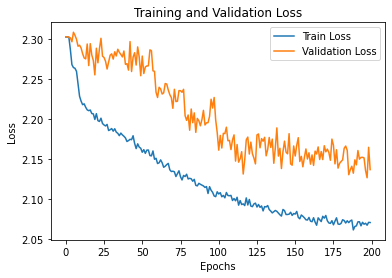

<Figure size 432x288 with 0 Axes>

In [ ]:
train_stats = pd.read_csv("/content/outputs/first-model-batch-base/train.csv", header=None)
Analytics.plot_loss(train_stats[1][:-1], train_stats[2][:-1], "first-model-batch-base")

Our best model reached about 42%

### 4-Class Problem

Having now realised that we do not have enough training data for this 10 class problem, we retrain the model on a 4 class problem (using crime, romance, scifi and fantasy). The results are much better!

We run the training 3 times to test the training stability.

In [ ]:
"""
Dataset reader to read the dataset from file
and perform transformations (vectorization)
on the source data
"""
class DatasetReader:
    def __init__(self, embedding_type, logger, sent_cleaner_conf=None, down_sample_conf=None):
        if sent_cleaner_conf is None:
            sent_cleaner_conf = get_default_sent_cleaner_conf_all_false()
        if down_sample_conf is None:
            down_sample_conf = get_default_down_sample_conf()

        # Member assignments
        self.logger = logger
        self.embedding_loader = EmbeddingLoader(embedding_type, logger)
        self.sent_cleaner_conf = sent_cleaner_conf
        self.down_sample_conf = down_sample_conf

    def read(self, path_to_zip, simple, model_name):
        # Reading from zip files, and storing in a dictionary with key is fim genre,
        # and value is list of films with plot
        initial_df = pd.DataFrame()

        with zipfile.ZipFile(path_to_zip) as z:
            for name in z.namelist():
                if name.endswith(".csv"):
                    self.logger.log(f'Loading data from {name}...')
                    x = pd.read_csv(z.open(name))
                    self.logger.log(f'Loading completed from {name}...')
                    initial_df = pd.concat([initial_df, x[['genre', 'plot']]], axis=0, ignore_index=True)
                    if name.split('/')[-2] not in ["scifi", "fantasy", "romance", "crime"]:
                      initial_df = initial_df.drop(initial_df.query(f"genre == '{name.split('/')[-2]}'").index)
                    
            self.logger.log("Dataframe (df) ready to be used!")

        df = self._down_sample(initial_df)
        df = df.dropna()

        # Shuffle the df
        df = df.sample(frac=1)

        self.logger.log(df['genre'].value_counts())
        Analytics.plot_value_counts(df, model_name, "full")
        if simple:
            self.logger.log("Preparing vectors using simple average")
            return self._prepare_dataset(df)
        else:
            self.logger.log("Preparing vectors using weighted TF-IDF average")
            return self._prepare_dataset_tfidf(df)

    def _down_sample(self, df):
        # Down sample drama
        for genre in FILMS_GENRE:
            sample_percent = self.down_sample_conf.get(genre, 0.0)
            df = df.drop(df.query(f"genre == '{genre}'").sample(frac=sample_percent).index)

        self.logger.log(df['genre'].value_counts())
        return df

    def _prepare_dataset(self, df):
        # Clean the plots
        cleaned_plots = df['plot'].apply(lambda x: SentCleaner(x, self.sent_cleaner_conf).clean_sent())
        # Create the mean embedding vector
        embed_vectors = torch.tensor(np.array([self.embedding_loader.get_mean(plot) for plot in list(cleaned_plots)]))
        X = embed_vectors
        self.logger.log (f"Mean vector result shape (embed_vectors) for {len(cleaned_plots)} plots: {embed_vectors.shape}")

        Y = torch.tensor(np.array(df['genre'].apply(lambda g: TARGET_LKP[g])))

        self.logger.log(f"Shape of X: {X.shape}")
        self.logger.log(f"Shape of Y: {Y.shape}")

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        Analytics.show_train_val_test_stats(y_train, y_val, y_test, self.logger)

        return X_train, X_test, y_train, y_test, X_val, y_val

    # Limitation: separate tfidf for test set
    def _prepare_dataset_tfidf(self, df):
        # Clean the plots
        cleaned_plots = df['plot'].apply(lambda x: SentCleaner(x, self.sent_cleaner_conf).clean_sent())

        # Calculate TFIDF
        tf_idf_vecs = TfIdfWeighter(cleaned_plots).get_tf_idf()
        embed_vectors = self.embedding_loader.get_tf_idf_weighted_mean(cleaned_plots, tf_idf_vecs)

        X = embed_vectors
        self.logger.log (f"Mean vector result shape (embed_vectors) for {len(cleaned_plots)} plots: {embed_vectors.shape}")
        Y = torch.tensor(np.array(df['genre'].apply(lambda g: TARGET_LKP[g])))

        self.logger.log(f"Shape of X: {X.shape}")
        self.logger.log(f"Shape of Y: {Y.shape}")

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        Analytics.show_train_val_test_stats(y_train, y_val, y_test, self.logger)

        return X_train, X_test, y_train, y_test, X_val, y_val



In [ ]:
# Download the final dataset
!gdown 1dhTF48AKpPBEq0ZeSstOSsS17A7ktmzl

# Download new configurations
!gdown 1dUw3Lf0b998DSuY3z-ptEYfVVVawxV7Q

# Fetch the data
!gdown 10fAkL5gOYjG0WcNIwZnZ1X9_n8pciT19
os.makedirs("/content/data/", exist_ok=True)
!cp /content/data_full4.zip /content/data/
path = "/content/data/data_full4.zip"

initial_df = pd.DataFrame()
with zipfile.ZipFile(path) as z:
  for name in z.namelist():
    print (name)
    print (name.split('/')[-2])
    if name.endswith(".csv"):
      print(f'Loading data from {name}...')
      x = pd.read_csv(z.open(name))
      print(f'Loading completed from {name}...')
      initial_df = pd.concat([initial_df,x[['genre','plot']]],axis=0,ignore_index=True)

      if name.split('/')[-2] not in ["scifi", "fantasy", "romance", "crime"]:
        initial_df = initial_df.drop(initial_df.query(f"genre == '{name.split('/')[-2]}'").index)

  print("Dataframe (df) ready to be used!")

initial_df

print(initial_df['genre'].value_counts())

"""
Configurations 
"""
# Fetch the configuration file that defines the experiments and begin
!rm config.json
!gdown 1tNu5VVyNMGWkD9BQtI29mqLM3pW7g-1t
!mkdir source_data 
!cp data_full3.zip source_data/ 

configs = get_configs("config-arch.json")
print(f"Number of experiments: {len(configs)}")

LOGFILE = "training_log.txt"
OUTPUT_DIR = "/content/outputs"

for idx_config, config in enumerate(configs):
    try:
        print(f"Starting with model {idx_config}: {config['model_name']} with config:\n{config}")
        os.makedirs(f"outputs/{config['model_name']}", exist_ok=True)
        _logger = Logger(f"{OUTPUT_DIR}/{config['model_name']}", LOGFILE, "mlp_clf.py")

        dataset_reader = DatasetReader(config['embedding_type'], _logger)
        _X_train, _X_test, _y_train, _y_test, _X_val, _y_val = dataset_reader.read(config['data_path'], config['simple'], config['model_name'])
        outcome = run_model(config['structure'], config['model_name'], config['lr'], config['epochs'], config['input_dim'], config['batch_size'], _logger, _X_train, _y_train, _X_val, _y_val, _X_test, _y_test)

        if outcome == 0:
            _logger.log ("Completed training and testing")
        else:
            _logger.log ("Failed")
    except KeyboardInterrupt as ke:
        print("Interrupted - quitting")
        break
    except Exception as e:
        print("Failed the previous run. Trying the next")
        print (e)        

Downloading...
From: https://drive.google.com/uc?id=1dhTF48AKpPBEq0ZeSstOSsS17A7ktmzl
To: /content/data_full4.zip
100% 7.18M/7.18M [00:00<00:00, 145MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dUw3Lf0b998DSuY3z-ptEYfVVVawxV7Q
To: /content/config-arch.json
100% 2.15k/2.15k [00:00<00:00, 2.71MB/s]
Downloading...
From: https://drive.google.com/uc?id=10fAkL5gOYjG0WcNIwZnZ1X9_n8pciT19
To: /content/data_full3.zip
100% 5.15M/5.15M [00:00<00:00, 200MB/s]
content/gdrive/MyDrive/CS5242_Project_Data_2/action/action_films.csv
action
Loading data from content/gdrive/MyDrive/CS5242_Project_Data_2/action/action_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data_2/action/action_films.csv...
content/gdrive/MyDrive/CS5242_Project_Data_2/adventure/adventure_films.csv
adventure
Loading data from content/gdrive/MyDrive/CS5242_Project_Data_2/adventure/adventure_films.csv...
Loading completed from content/gdrive/MyDrive/CS5242_Project_Data_2/adventure/adventure_films

<Figure size 432x288 with 0 Axes>

In [ ]:
# Let us view test loss from the 3 runs
!tail -5 /content/outputs/first-model-batch-4clf-1/training_log.txt
!tail -5 /content/outputs/first-model-batch-4clf-2/training_log.txt
!tail -5 /content/outputs/first-model-batch-4clf-3/training_log.txt

16/11/2022 14:33:48: Epoch: 199 | Train Loss: 2.143 | Valid Loss : 1.790 | Valid Acc  : 0.674
16/11/2022 14:33:50: Training time: 138.346734484001
16/11/2022 14:33:50: Next line is test loss - ignore the train loss there
16/11/2022 14:33:50: Epoch: 0 | Train Loss: 11.111 | Valid Loss : 1.834 | Valid Acc  : 0.624
16/11/2022 14:33:50: Completed training and testing
16/11/2022 14:37:42: Epoch: 199 | Train Loss: 2.142 | Valid Loss : 1.971 | Valid Acc  : 0.573
16/11/2022 14:37:44: Training time: 131.97618845800025
16/11/2022 14:37:44: Next line is test loss - ignore the train loss there
16/11/2022 14:37:44: Epoch: 0 | Train Loss: 11.111 | Valid Loss : 1.916 | Valid Acc  : 0.579
16/11/2022 14:37:44: Completed training and testing
16/11/2022 14:41:14: Epoch: 199 | Train Loss: 2.140 | Valid Loss : 1.930 | Valid Acc  : 0.539
16/11/2022 14:41:16: Training time: 131.2530084129994
16/11/2022 14:41:16: Next line is test loss - ignore the train loss there
16/11/2022 14:41:16: Epoch: 0 | Train Loss: 

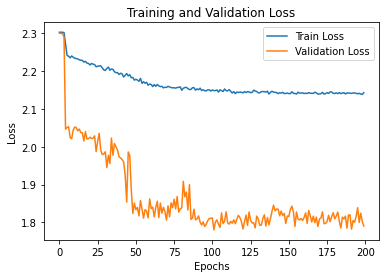

<Figure size 432x288 with 0 Axes>

In [ ]:
train_stats = pd.read_csv("/content/outputs/first-model-batch-4clf-1/train.csv", header=None)
Analytics.plot_loss(train_stats[1][:-1], train_stats[2][:-1], "first-model-batch-base")

In [ ]:
def create_animated_gifs_acc(model_name):
    from PIL import Image
    Analytics.create_dirs_if_not_present(model_name)
    sort_fn = lambda x: int(os.path.basename(x).split('/')[-1].split('.')[0])
    images = [Image.open(image) for image in sorted(glob.glob(f"/content/outputs/{model_name}/acc_by_class/*.png"), key=sort_fn)]
    images[0].save(f"/content/outputs/{model_name}/acc_by_class/accuracies.gif", format="GIF", append_images=images,
                    save_all=True, duration=len(images) / 2, loop=0)

create_animated_gifs_acc("first-model-batch-4clf-1")
print ("Accuracies by class over the epochs ")
from IPython.display import Image
Image(open('/content/outputs/first-model-batch-4clf-1/acc_by_class/accuracies.gif','rb').read())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print ("Confusion matrix over the epochs ")
from IPython.display import Image
Image(open('/content/outputs/first-model-batch-4clf-1/confusion/confusion.gif','rb').read())

Output hidden; open in https://colab.research.google.com to view.

These results more promising, and show that the embeddings are capturing the meaning better. We also observe that removing the text cleaning actually improves the result - possibly because the word embeddings sum up the meaning better without intervention from the text cleaning approach.

We also observe that the model is only focussing on predicting two classes even when not constrained (it can still predict any of the 10 classes). 

In the next notebook we look at CNN and RNN based approaches. These issues are mitigated there.

